## Predicting Salaries in the Data Science/Machine Learning Community

We use a clean version of the survey data from the Kaggle DS & ML Survey 2020 (see the notebook Capstone 2 Build Features). The dataset contains the selection of employed individuals participating in the survey with an answer to the compensation question. The file has a continuous version of the income range, user demographics (age, gender, education level, working status), their data science and machine learning knowledge and experience, and methods and tools they use or would like to get familiar with. The survey was distributed to the entire Kaggle community through the Kaggle (opted-in) email list and promoted on the Kaggle website and Kaggle Twitter channel. Given the large presence of Kaggle in the community and the size of the survey, we can interpret results from the survey as representing the DS/ML community. 

The survey is rich with a long list of potential features that can be used to predict salaries. That said, the list is extensive and can lead to model overfitting. To mitigate, this problem we will use cross-validation methods to evaluate model fit and select the best method to predict salaries.

We will try different ML modeling approaches to predict salaries, starting with a dataset already cleaned that includes a set of pre-identify features. The data excludes students and unemployed individuals, or other surveys not reporting compensation. See the notebook [Build Features](https://github.com/lg-42/Springboard_projects/blob/32b7a40a84bb380deafbbe775411b7f8b8e00ec1/Data%20Science%20Salaries/Capstone%202%20-%20Build%20Features.ipynb) with the code developing the analysis dataset.

Our target variable is defined current compensation, which originally came as a range and it was transformed to a continuous variable assigning the range middle point. The covariates in the data can be classified into demographic characteristics, geographic region, job position, experience, and DS/ML tools.
* Demographic variables: age level (midpoint from ranges), education (midpoint from ranges), and gender (male/female/other indicator).
* Geographic region: indicators for top 10 respondent countries (India, US, Brazil, Japan, Russia, UK, Germany, Nigeria, Spain, and Canada), and indicators for low income, medium-low income, medium-high income, and high income countries (data from the World Population Review).
* Job related: job title (indicators), and number of employees at the company (midpoint from ranges).
* Experience: years of programming experience (midpoint from ranges), years of experience using machine learning methods (none/some/more than 2 yrs)
* DS/ML tools: number of languages used regularly, and indicators for the following: Python, R, SQL, C, C++, Java, Javascript, Julia, Swift, Bash, or Matlab use, use of visualization methods, cloud computing platform use, deep learning workstation use, personal computer/laptop use, advance statistical software (SPSS, SAS, etc.) use, basic statistical software (Excel, Google Sheets, etc) use, business intelligence software use, or local development environment.

In [2]:
# Import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import sklearn components
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# Read clean file
survey_features = pd.read_json("./DS_ML_Survey_feature_sel_3.json", compression=None)
print("Shape of original dataframe: ",survey_features.shape)


Shape of original dataframe:  (10729, 129)


In [5]:
# Drop missing values
print(survey_features.info(verbose=True,show_counts=True))
### we use the categorical indicators for  experience
survey_inc = survey_features.drop('mlexp_or', axis=1)
survey_inc.shape
survey_inc = survey_inc.dropna()
survey_inc.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10729 entries, 1 to 20035
Data columns (total 129 columns):
 #    Column                                                                         Non-Null Count  Dtype  
---   ------                                                                         --------------  -----  
 0    age_lev                                                                        10677 non-null  float64
 1    educ                                                                           10571 non-null  float64
 2    prog_exp                                                                       10729 non-null  float64
 3    empl_size                                                                      10729 non-null  int64  
 4    Kaggle                                                                         10729 non-null  int64  
 5    Colab                                                                          10729 non-null  int64  
 6    Azure       

(10472, 128)

In [6]:
survey_inc.describe()

,age_lev,educ,prog_exp,empl_size,Kaggle,Colab,Azure,Paperspace_Gradient,Binder_JupyterHub,Code_Ocean,IBMWatson_Studio,Amazon_SagenmakerStudio,Amazon_EMR,Google_Cloud_AIPlatform,Google_Cloud_Datalab,Databricks,No_notebook,Other_notebook,GPUs,TPUs,None,Other,Scikit-learn,TensorFlow,Keras,Pytorch,Fast.ai,MXNet,Xgboost,LightGBM,CatBoot,Prophet,H2O_3,Caret,Tidymodels,JAX,No_MLFrame,Other_MLFrame,Linear Logistic Reg,Decision Trees Random Forest,Gradient Boosting Machines,Bayesian Approaches,Evolucionary Aproaches,Dense Neural Networks,Convolutional Neural Networks,Generative Adversarial Networks,Recurrent Neural Networks,Transformer Networks,No_MLAlg,Other_MLAlg,General Purpose Image/Video Tools,Image Segmentation Methods,Object Detection Methods,Image_Classification,Generative Networks,No_CompVMeth,Other_CompVMeth,Word Embeddings/vectors,Encoder-decoder models,Contextualized Embeddings,Transformer Language Models,No_NLPMeth,Other_NLPMeth,PL_Python,PL_R,PL_SQL,PL_C,PL_C++,PL_Java,PL_Javascript,PL_Julia,PL_Swift,PL_Bash,PL_MATLAB,PL_None,PL_Other,Language Number,Country_Low Income,Country_Medium Low Inc,Country_Medium High Inc,Country_High Income,_Brazil,_Canada,_Germany,_India,_Japan,_Nigeria,_Other,_Russia,_Spain,_United Kingdom,_United States,Role_Business Analyst,Role_Currently not employed,Role_DBA/Database Engineer,Role_Data Analyst,Role_Data Engineer,Role_Data Scientist,Role_Machine Learning Engineer,Role_Other,Role_Product/Project Manager,Role_Research Scientist,Role_Software Engineer,Role_Statistician,Role_Student,"Platform_A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)","Platform_A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)",Platform_A personal computer or laptop,Platform_None,Platform_Other,"MainTool_Advanced statistical software (SPSS, SAS, etc.)","MainTool_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","MainTool_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","MainTool_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","MainTool_Local development environments (RStudio, JupyterLab, etc.)",MainTool_Other,Gender_Other,Male,Woman,More than 2yrs ML Exp,No ML Experience,Some ML Experience,Q24_lb_wage,Q24_ub_wage,wage
count,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.00000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.00000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.0,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.0,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000
mean,36.417685,3.815890,7.243363,4025.773491,0.324389,0.343774,0.055768,0.010218,0.112777,0.006016,0.044309,0.035714,0.015565,0.073911,0.073529

### EVALUATION METHODS

We use three different measures to evaluate model fit. The mean absolute error (MAE) and the mean squared error (MSE) will give us a measure of the size of the errors, with the second having a higher penalization on larger errors. A lower MAE or MSE implies a better fit. The third method is the coefficient of determination, or R2, also commonly used. It's based on squared errors and it can be interpreted as a proportion. The R2 compares the model fit with a prediction based on simple averages. A higher R2 implies a better fit.

### LINEAR MODELS

Besides using cross validation, we will fit two models, a basic model with just demographic variables, experience, and country of origin and a full model were we also include information on the type of position and tools used by the individual. This can help evaluating how much the additional features add to the predictive power of the model.

We fit the regular linear regression model, and the Ridge and Lasso regression models. 

In [7]:
# Define group of variables to use when fitting the models
demog = ['age_lev','educ','Woman','Gender_Other']
exp = ['prog_exp','Language Number','More than 2yrs ML Exp','Some ML Experience']
countrygrp = ['Country_Medium Low Inc','Country_Medium High Inc','Country_High Income']
country = ['_India', '_United States', '_Brazil', '_Japan', '_Russia', '_United Kingdom', '_Germany', '_Nigeria', '_Spain', '_Canada']
languages=['PL_Python','PL_R','PL_SQL','PL_C','PL_C++','PL_Java','PL_Javascript','PL_Julia','PL_Swift','PL_Bash','PL_MATLAB']
tools=['vizlib','cloudcomp','Platform_A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)','Platform_A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)','Platform_A personal computer or laptop','MainTool_Advanced statistical software (SPSS, SAS, etc.)','MainTool_Basic statistical software (Microsoft Excel, Google Sheets, etc.)','MainTool_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)','MainTool_Local development environments (RStudio, JupyterLab, etc.)']
tools2=['GPUs','TPUs','Scikit-learn','TensorFlow','Keras','Pytorch','Fast.ai','MXNet','Xgboost','LightGBM','CatBoot','Prophet','H2O_3','Caret','Tidymodels','JAX']
tools3=['Linear Logistic Reg','Decision Trees Random Forest','Gradient Boosting Machines','Bayesian Approaches','Evolucionary Aproaches','Dense Neural Networks','Transformer Networks']
tools4=['General Purpose Image/Video Tools','Image Segmentation Methods', 'Object Detection Methods','Image_Classification','Generative Networks','Word Embeddings/vectors','Encoder-decoder models','Contextualized Embeddings','Transformer Language Models']
job=['empl_size','Role_Business Analyst','Role_Currently not employed','Role_DBA/Database Engineer','Role_Data Analyst','Role_Data Engineer','Role_Data Scientist','Role_Machine Learning Engineer','Role_Product/Project Manager','Role_Research Scientist','Role_Software Engineer','Role_Statistician','Role_Student']


In [8]:
# Create a train and test set to fit the basic model and the full model
# We scale all covariate variables and we transform the outcome variable using the natural logarithm function

# define scaler
scaler = StandardScaler()
# Basic Model
X_basic = scaler.fit_transform(survey_inc[sum([demog,exp,countrygrp,country],[])])
# Full Model
X_full = scaler.fit_transform(survey_inc[sum([demog,exp,countrygrp,country,languages,tools,tools2, tools3, tools4,job],[])])
X_full_col = sum([demog,exp,countrygrp,country,languages,tools,tools2, tools3, tools4,job],[])
 
Y = np.log(survey_inc.wage)

# Create a training and test set for the basic model and the full model
Xbasic_train, Xbasic_test, Ybasic_train, Ybasic_test = train_test_split(X_basic, Y.to_numpy(), test_size = 0.3, random_state = 42)
Xfull_train, Xfull_test, Yfull_train, Yfull_test = train_test_split(X_full, Y.to_numpy(), test_size = 0.3, random_state = 42)


#### Run the Basic Model (a few covariates)

In [9]:
# Apply Cross Validation to the Linear Regression Fit - Explore alternative models penalizing for number of variables included
# in the model: Ridge and Lasso regression 

reg_basic=LinearRegression()
cv_scr_basic = cross_validate(reg_basic, Xbasic_train, Ybasic_train, cv=4, scoring=['r2','neg_mean_absolute_error'])
reg_basic_eval = ["Linear Reg - Basic",cv_scr_basic['test_neg_mean_absolute_error'].mean()*-1,cv_scr_basic['test_neg_mean_absolute_error'].std(),cv_scr_basic['test_r2'].mean(),cv_scr_basic['test_r2'].std()]

rdgreg_basic=Ridge()
cv_scr_rdg_basic = cross_validate(rdgreg_basic,  Xbasic_train, Ybasic_train, cv=4, scoring=['r2','neg_mean_absolute_error'])
rdgreg_basic_eval = ["Ridge Reg -  Basic",cv_scr_rdg_basic['test_neg_mean_absolute_error'].mean()*-1,cv_scr_rdg_basic['test_neg_mean_absolute_error'].std(),cv_scr_rdg_basic['test_r2'].mean(),2*cv_scr_rdg_basic['test_r2'].std()]

lssreg_basic=Lasso()
cv_scr_lss_basic = cross_validate(lssreg_basic, Xbasic_train, Ybasic_train, cv=4, scoring=['r2','neg_mean_absolute_error'])
lssreg_basic_eval = ["Lasso Reg - Basic", cv_scr_lss_basic['test_neg_mean_absolute_error'].mean()*-1,cv_scr_lss_basic['test_neg_mean_absolute_error'].std(),cv_scr_lss_basic['test_r2'].mean(),2*cv_scr_lss_basic['test_r2'].std()]

pd.DataFrame([reg_basic_eval,rdgreg_basic_eval, lssreg_basic_eval],columns=["Model","Avg MAE","MAE SD","Avg R2", "R2 SD"])


,Model,Avg MAE,MAE SD,Avg R2,R2 SD
0,Linear Reg - Basic,1.289490,0.009346,0.358119,0.014919
1,Ridge Reg - Basic,1.289506,0.009344,0.358122,0.029837
2,Lasso Reg - Basic,1.732696,0.020664,-0.000369,0.000276


#### Linear model cross validation with full set of covariates

In [10]:
# Full models

reg_full=LinearRegression()
cv_scr_full = cross_validate(reg_full, Xfull_train, Yfull_train, cv=4, scoring=['r2','neg_mean_absolute_error'])
reg_full_eval = ["Linear Reg - Full",cv_scr_full['test_neg_mean_absolute_error'].mean()*-1,cv_scr_full['test_neg_mean_absolute_error'].std(),cv_scr_full['test_r2'].mean(),cv_scr_full['test_r2'].std()]

rdgreg_full=Ridge()
cv_scr_rdg_full = cross_validate(rdgreg_full,  Xfull_train, Yfull_train, cv=4, scoring=['r2','neg_mean_absolute_error'])
rdgreg_full_eval = ["Ridge Reg -  Full",cv_scr_rdg_full['test_neg_mean_absolute_error'].mean()*-1,cv_scr_rdg_full['test_neg_mean_absolute_error'].std(),cv_scr_rdg_full['test_r2'].mean(),2*cv_scr_rdg_full['test_r2'].std()]

lssreg_full=Lasso()
cv_scr_lss_full = cross_validate(lssreg_full, Xfull_train, Yfull_train, cv=4, scoring=['r2','neg_mean_absolute_error'])
lssreg_full_eval = ["Lasso Reg - Full", cv_scr_lss_full['test_neg_mean_absolute_error'].mean()*-1,cv_scr_lss_full['test_neg_mean_absolute_error'].std(),cv_scr_lss_full['test_r2'].mean(),2*cv_scr_lss_full['test_r2'].std()]

pd.DataFrame([reg_full_eval,rdgreg_full_eval, lssreg_full_eval],columns=["Model","Avg MAE","MAE SD","Avg R2", "R2 SD"])


,Model,Avg MAE,MAE SD,Avg R2,R2 SD
0,Linear Reg - Full,1.206639,0.009010,0.421499,0.020254
1,Ridge Reg - Full,1.206642,0.009014,0.421508,0.040515
2,Lasso Reg - Full,1.732696,0.020664,-0.000369,0.000276


#### Final Linear Model Fit

Applying a linear model using just the main variables gives a decent result, with a MAE of 1.29 on the train set and an R2 of 0.36. Since we fit the model on the log of the outcome variable, the 1.29 MAE can be interpreted as a mean absolute error of about 29%. The model fit can be improved by using the full set of variables selected, with a median MAE of 1.20 and an R2 of 0.42. Using the Ridge regression instead of regular OLS doesn't seem to improve the model, and a Lasso regression actually gives a much worse fit. The fit on the test set gives similar results.
The plot of errors against the transformed outcome shows that the errors don't seem random, specially for low outcome values. A non-linear model may get a better fit.


In [33]:
# Use the test set to evaluate the fit of the full models (using all covariates)

def model (form, score, scoref):
    if form == Lasso:
        reg = form(max_iter=10000)
    else:
        reg = form()
    reg.fit(Xfull_train,Yfull_train)
    params = list(reg.coef_)
    test_scr = scoref(Yfull_test, reg.predict(Xfull_test))
    return test_scr, params

def modcomp (form, matrix1, num):
    matrix1[num,0], coef = model(form = form, score = 'neg_mean_squared_error', scoref = mean_squared_error)
    matrix1[num,1], _c = model(form = form, score = 'neg_mean_absolute_error', scoref = mean_absolute_error)
    matrix1[num,2], _c = model(form = form, score = 'r2', scoref = r2_score)
    return coef

linear_models =  np.empty(shape=(3,3),dtype='object')

prms = modcomp(LinearRegression,linear_models, 0)

param1=pd.Series(prms,index=X_full_col)
prms = modcomp(Ridge,linear_models, 1)
param2 = pd.Series(prms,index=X_full_col)
prms = modcomp(Lasso,linear_models, 2)
param3 = pd.Series(prms,index=X_full_col)

params = pd.concat([param1,param2,param3],axis=1)
params.columns=["LinearRegression","Ridge","Lasso"]
models_comp = pd.DataFrame(linear_models,index=["Linear Regression","Ridge Regression", "Lasso Regression"],
                           columns=["MSE","MAE","R2"])
pd.options.display.float_format = '{:,.3f}'.format


In [12]:
models_comp


,MSE,MAE,R2
Linear Regression,2.304,1.201,0.421
Ridge Regression,2.304,1.201,0.421
Lasso Regression,3.979,1.728,-0.000


In [13]:
params

,LinearRegression,Ridge,Lasso
age_lev,0.222,0.222,0.000
educ,0.076,0.076,0.000
Woman,-0.150,-0.150,-0.000
Gender_Other,-0.032,-0.032,0.000
prog_exp,0.160,0.160,0.000
Language Number,0.216,0.215,0.000
More than 2yrs ML Exp,0.265,0.264,0.000
Some ML Experience,0.049,0.049,-0.000
Country_Medium Low Inc,-0.040,-0.040,-0.000
Country_Medium High Inc,0.003,0.003,-0.000


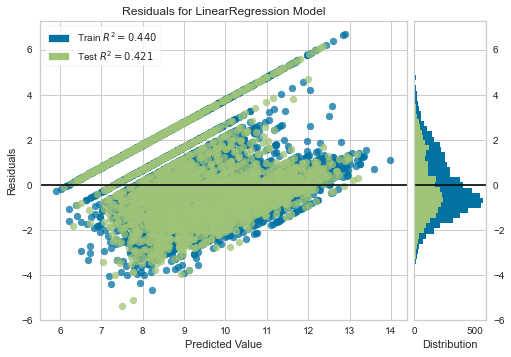

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [14]:
from yellowbrick.regressor import ResidualsPlot

modelp = LinearRegression()
linear_mod_plots = ResidualsPlot(modelp)

linear_mod_plots.fit(Xfull_train, Yfull_train)  # Fit the training data to plots function
linear_mod_plots.score(Xfull_test, Yfull_test)  # Evaluate the model on the test data
linear_mod_plots.show()       

### RANDOM FOREST

We can model and predict salaries using the Random Forest, a type of bagging methods that relies on the strength of fitting multiple trees and averages. The random forest randomizes not only samples but also the features used to build each of the trees. We first fit the model with some basic and default parameters, and then we run a grid search to identify the best parameters for the forest.

In [15]:
# Fit the Random Forest Regression
# We first use the model with basic options, and then we do a gridsearch to find the optumum value for the random forest parameters.

# Train the Model
rf_mod = RandomForestRegressor(n_estimators = 1000, max_features='auto', random_state = 42, oob_score=True)
rf_mod.fit(Xfull_train,Yfull_train.ravel())

# Score based on training set fit
rf_def_eval = ["Random Forest Default - Training set", rf_mod.oob_score_]
print(rf_def_eval)

print('RANDOM FOREST EVALUATION ON TEST SET')
# Calculate the errors using the test set
Yfull_test_pred = rf_mod.predict(Xfull_test)
errors_rff = Yfull_test_pred - Yfull_test

rf_full_eval = ["Random Forest",abs(errors_rff).mean(),rf_mod.score(Xfull_test, Yfull_test)]

print(rf_full_eval)


['Random Forest Default - Training set', 0.43785300630902957]
RANDOM FOREST EVALUATION ON TEST SET
['Random Forest', 1.1569160444063074, 0.43602531845117054]


The random forest model improves the fit when compared with the linear model. We can explore the more important features identified by the forest to predict salaries. Country income level is, not surprisingly, by far the most relevant variable. With similar significance follow employer size, the individual age, and programming experience. But before looking further, let's see if the model can be improved.

In [16]:
# Compute the MAE in dollars
Ytest_error=np.exp(Yfull_test_pred)-np.exp(Yfull_test)
print(np.abs(Ytest_error).mean())

25735.112856121814


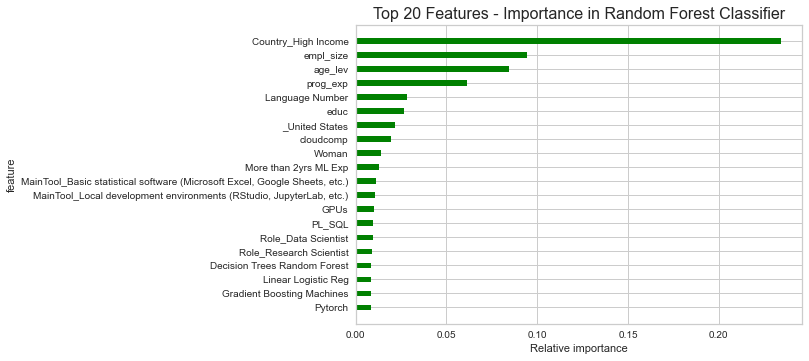

In [17]:
# Identify the top features used in the model for prediction
y_fi = pd.Series(rf_mod.feature_importances_,index=X_full_col)
y_fi_top20 = y_fi.sort_values()[-20:]

#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y_fi_top20)) # the x locations for the groups
ax.barh(ind, y_fi_top20, width, color='green')
ax.set_yticks(ind+width/20)
ax.set_yticklabels(y_fi_top20.index, minor=False)
plt.title('Top 20 Features - Importance in Random Forest Classifier', size=16)
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.savefig("In Depth-RandomForestFeatures.png")


#### TUNNING THE RANDOM FOREST REGRESSION

We tried the random forest model using the full set of features and it improves the linear model fit, but can we improve the model further? We use grid search to identify the best values for the parameters.

#### Extensive randomized search over multiple parameters

We try an extensive search over all parameters in the random forest model. We first create a grid with points for each parameter, to fit the random forest and then we use the randomized search (RandomizedSearchCV) estimator, that will pick a random set of parameters from the grid and fit the model applying the cross validation method. Once the function finds the optimum set of parameters, we run a comprehensive search around them to refine the optimum point.

In [18]:
## DEFINE THE GRID

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False]}


In [19]:
## USE THE GRID TO PERFORM A RANDOM SEARCH FOR THE BEST HYPERPARAMETERS
## USING RandomizedSearchCV()

# Define the model type
rf = RandomForestRegressor()

# Define the randomized search using the function RandomizedSearchCV with 3 fold cross validation and a 100 sample of parameter combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(Xfull_train, Yfull_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 54.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [20]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [22]:
## RUN A COMPREHENSIVE GRID SEARCH AROUND THE IDENTIFIED PARAMETERS
## DEFINE A NEW SMALLER GRID AND RUN THE SEARCH USING GridSearchCV()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1550, stop = 1650, num = 3)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(90, 100, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [9, 10, 11]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# Method of selecting samples for training each tree
bootstrap = [False]
# Create the random grid
parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_bf_mod = RandomForestRegressor()
gsrf = GridSearchCV(rf_bf_mod,parameters) 
gsrf.fit(Xfull_train,Yfull_train.ravel())

print(gsrf.score(Xfull_test, Yfull_test))

0.4644359709567296


In [23]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

### Final Random Forest Model

The new forest fit with the identified parameters from the grid search shows a large improvement in the model fit. Using the R2 measure it's a clear improvement not only on the linear model fit, but also on the Random Forest fit using the default parameters. Using the final identified parameters, we train the Random Forest and evaluate it on the test set. Then we look into the most important features identified in this final model.

In [24]:
# Train the Model - No boostrap
rf_mod_optnb = RandomForestRegressor(n_estimators = 1600, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', max_depth=None, bootstrap=False, random_state = 42)
rf_mod_optnb.fit(Xfull_train,Yfull_train.ravel())

print('RANDOM FOREST EVALUATION ON TEST SET')
# Calculate the errors using the test set
Yfull_test_predoptnb = rf_mod_optnb.predict(Xfull_test)
errors_rf_optnb = Yfull_test_predoptnb - Yfull_test

rf_opt_full_eval = ["Random Forest",abs(errors_rf_optnb).mean(),rf_mod_optnb.score(Xfull_test, Yfull_test)]

print(rf_opt_full_eval)


RANDOM FOREST EVALUATION ON TEST SET
['Random Forest', 1.1479419159955813, 0.4648081863077428]


In [25]:
# Compute the MAE in dollars
Ytest_error=np.exp(Yfull_test_predoptnb)-np.exp(Yfull_test)
print(np.abs(Ytest_error).mean())


25954.817237681862


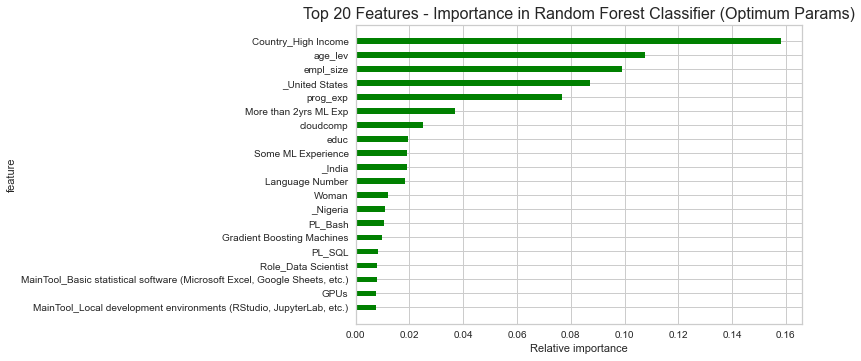

In [26]:
rf_opt_features = pd.Series(rf_mod_optnb.feature_importances_,index=X_full_col)
rf_opt_features_top20 = rf_opt_features.sort_values()[-20:]

#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(rf_opt_features_top20)) # the x locations for the groups
ax.barh(ind, rf_opt_features_top20, width, color='green')
ax.set_yticks(ind+width/20)
ax.set_yticklabels(rf_opt_features_top20.index, minor=False)
plt.title('Top 20 Features - Importance in Random Forest Classifier (Optimum Params)', size=16)
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.savefig("In Depth-RandomForestFeatures.png")


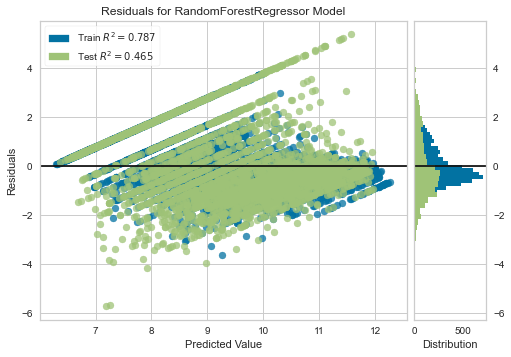

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [27]:

modelprf = RandomForestRegressor(n_estimators = 1600, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', max_depth=None, bootstrap=False, random_state = 42)
linear_mod_plots = ResidualsPlot(modelprf)

linear_mod_plots.fit(Xfull_train, Yfull_train)  # Fit the training data to plots function
linear_mod_plots.score(Xfull_test, Yfull_test)  # Evaluate the model on the test data
linear_mod_plots.show()       

Again, the feature with the most explanatory power is the indicator for country of residence being in the high-income level group, followed by the person's age and employer size. With the US being one of the top respondents and with high salary levels, an indicator of the person residing in the US is among the top variables. Programming experience in general and in particular having more than 2 years of machine learning experience also have high explanatory power.

The errors from the fit are still clearly not random. The Random Forest gives a decent fit, but it seems to overestimate salaries when they are on the lower end of the spectrum and underestimate them when they are on the high end of the spectrum.

### Compare all Models

The Random Forest model using all covariates has the best fit. There is still a large amount of unexplained variation, with a significant error, not explained by the covariates. However, there are a few features that stand out in their explanation power. Of course, country of residence is highly relevant. In particular, being from a high-income country, or a US or Nigeria residence indicators, are among the top explanatory variables. The second set of variables with high prediction power are related to experience: age, programming experience, significant experience (more than 2 years) in machine learning methods. Employer size is another highly relevant variable. Finally, the knowledge and use of some specific tools or environment have also significant predictive power. 

In [34]:
models_comp.reset_index(level=0, inplace=True)
models_comp.rename(columns={'index':'Model'},inplace=True)
#rfeval = pd.DataFrame([["Random Forest - Basic",(errors_rf_opt**2).mean(), abs(errors_rf_opt).mean(), rf_mod.score(Xfull_test, Yfull_test)],["Random Forest - Optimized",(errors_rf_opt**2).mean(), abs(errors_rf_opt).mean(), rf_mod_opt.score(Xfull_test, Yfull_test)]],columns=["Model","MSE","MAE","R2"])
rfeval = pd.DataFrame([["Random Forest - Basic",(errors_rff**2).mean(), abs(errors_rff).mean(), rf_mod.score(Xfull_test, Yfull_test)],["Random Forest - Optimized",(errors_rf_optnb**2).mean(), abs(errors_rf_optnb).mean(), rf_mod_optnb.score(Xfull_test, Yfull_test)]],columns=["Model","MSE","MAE","R2"])
models_comp.append(rfeval)


,Model,MSE,MAE,R2
0,Linear Regression,2.304,1.201,0.421
1,Ridge Regression,2.304,1.201,0.421
2,Lasso Regression,3.979,1.728,-0.000
0,Random Forest - Basic,2.244,1.157,0.436
1,Random Forest - Optimized,2.129,1.148,0.465
